# Tutorial Julia for Data Science

## 6 Regressione

Questa parte riguarda creazione e rappresentazione grafica di modelli di regressione in Julia.   
Vedremo modelli lineari semplici, generici (logistic) e anche non lineari.

### Modelli Lineari
Vediamo tre modi per fittare un modello lineare su dei dati, prima creiamo i nostri dati (dop0o aver svolto il setup dell'ambiente).

In [16]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using Plots
using Statistics
using StatsBase
using PyCall
using DataFrames
using GLM
using Tables
using XLSX
using MLBase
using RDatasets
using LsqFit
using DataStructures

mkpath("downloads")
mkpath("out")

 Activating environment at `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\tutorial\Project.toml`


"out"

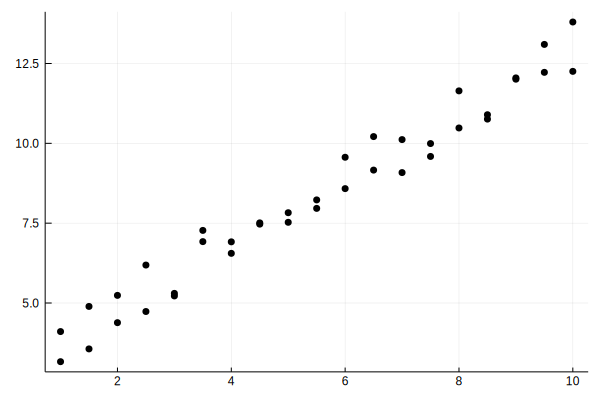

In [2]:
xvals = repeat(1:0.5:10, inner=2)
yvals = 3 .+ xvals .+ 2 .* rand(length(xvals)) .-1
scatter(xvals, yvals, color=:black, leg=false)

Abbiamo creato i nostri dati in modo che siano uno linearmente relazionato con l'altro (più un fattore di errore), perciò il grafico mostrerà relazione lineare tra i dati.

Creiamo adesso un modello lineare  $ Y = \beta_0 + \beta_1 X + \varepsilon $    
Approssimando i parametri con $$ \beta_0 \approx \hat{\beta_0} = E[Y] + \hat{\beta_1}E[X] $$
$$ \beta_1 \approx \hat{\beta_1} = \rho_{XY}\frac{\sigma_Y}{\sigma_X} $$

In [10]:
function find_best_fit(xvals,yvals)
    meanx = mean(xvals)
    meany = mean(yvals)
    stdx = std(xvals)
    stdy = std(yvals)
    r = cor(xvals,yvals)
    b1_hat = r*stdy/stdx
    b0_hat = meany - b1_hat*meanx
    return b1_hat,b0_hat
end

b1_hat,b0_hat = find_best_fit(xvals,yvals) #
y_hat = b1_hat .* xvals .+ b0_hat
resid = y_hat-yvals
MSE = mean(resid.^2)

0.29076670717633396

y_hat = { $ \hat{Y_i} : \hat{Y_i}  = \hat{\beta_0} +  \hat{\beta_1}X_i $ }  
resid = { $ e_i : e_i = Y_i - \hat{Y_i}$ }  
MSE = $ \frac1n\sum_{i=1}^{n}(Y_i - \hat{Y_i})^2 = \frac1n\sum_{i=1}^{n}(e_i)^2$ 

Vediamo un plot tra residui e predittore X per controllare se ci siano pattern su cui migliorare il modello, poi plottiamo la linea di regressione sui dati.

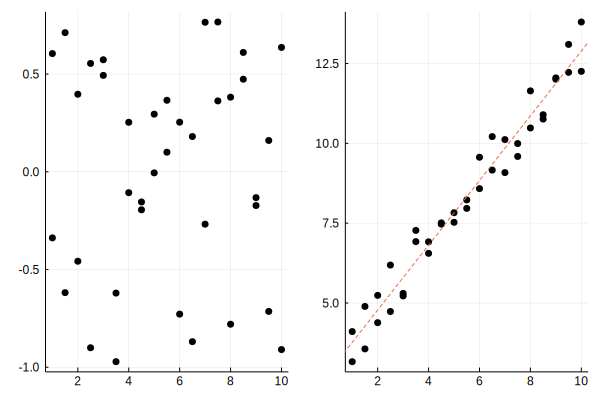

In [12]:
plot1 = scatter(xvals, resid, color=:black, leg=false)
plot2 = scatter(xvals, yvals, color=:black, leg=false)
Plots.abline!(b1_hat, b0_hat, line=:dash)
plot(plot1,plot2)

Non ci sembrano esser pattern particolari e il modello sembra fittare bene i dati.

Vediamo ora come creare un modello simile con un solo comando in Julia tramite numpy diu python:

  0.000397 seconds (45 allocations: 2.250 KiB)


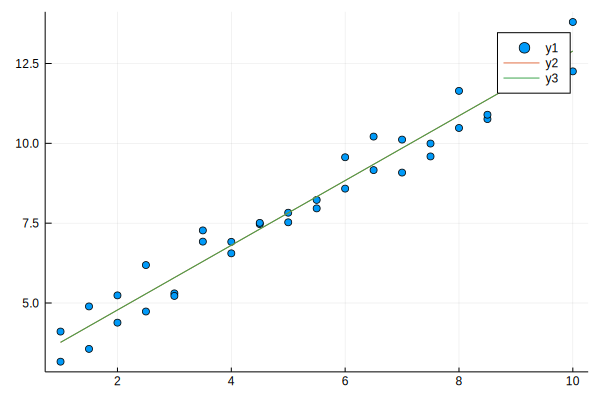

In [14]:
np = pyimport("numpy");
xdata = xvals
ydata = yvals
@time myfit = np.polyfit(xdata, ydata, 1);
ynew2 = collect(xdata) .* myfit[1] .+ myfit[2];
scatter(xvals,yvals)
plot!(xvals,y_hat)
plot!(xvals,ynew2)

Vediamo che ployfit ha creato il nostro stesso modello.

Vediamo ora lm()

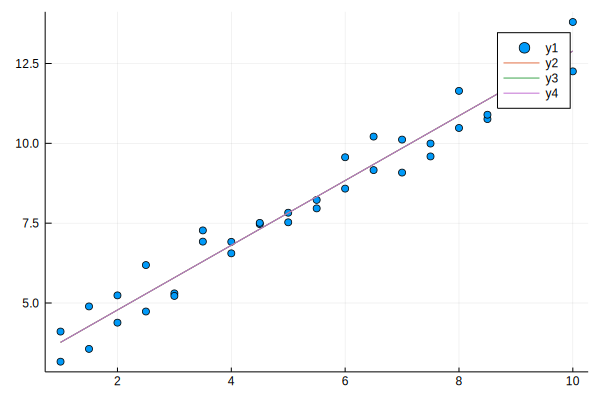

In [15]:
data = DataFrame(X=xdata, Y=ydata)
ols = lm(@formula(Y ~ X), data)
plot!(xdata,predict(ols))

I tre metodi han tutti prodotto lo stesso modello.

Vediamo ora come usare GLM.lm per creare modelli lineari di dati un pò più complessi.  
Vedremo un dataset sulle vendite di case in america divise per stato.  
Cercheremo di creare modelli, uno per ogni stato, che predicano il numero di case vendute in base al numero di case in vendita usando dati relativi a febbraio 2020. 

In [17]:
file = download("https://github.com/JuliaAcademy/DataScience/blob/master/data/zillow_data_download_april2020.xlsx?raw=true",
    "downloads/zillow_data_download_april2020.xlsx")
R = XLSX.readxlsx("downloads/zillow_data_download_april2020.xlsx")# carichiamo file excel, op lenta

"downloads/zillow_data_download_april2020.xlsx"

In [24]:
sale_counts = R["Sale_counts_city"][:]
df_sale_counts = DataFrame(sale_counts[2:end,:],Symbol.(sale_counts[1,:]))

monthly_listings = R["MonthlyListings_City"][:]
df_monthly_listings = DataFrame(monthly_listings[2:end,:],Symbol.(monthly_listings[1,:]))

monthly_listings_2020_02 = df_monthly_listings[!,[1,2,3,4,5,end]]
rename!(monthly_listings_2020_02, Symbol("2020-02") .=> Symbol("listings"))
# monthly_listings_2020_02 è df (id regione, case in vendita nel febb 2020)

sale_counts_2020_02 = df_sale_counts[!,[1,end]]
rename!(sale_counts_2020_02, Symbol("2020-02") .=> Symbol("sales"))
# sale counts 2020_02 è df (id regione, vendite nel febb 2020)

Feb2020data = innerjoin(monthly_listings_2020_02,sale_counts_2020_02,on=:RegionID) #, type="outer")
#  feb2020data è df con (id regione, vendite,case in vendita)
dropmissing!(Feb2020data)#rimuoviamo dati missing
sales = Feb2020data[!,:sales]#array delle vendite
counts = Feb2020data[!,:listings]#array delle case in vendita
states = Feb2020data[!,:StateName]#array degli stati
C = counter(states)
@show C.map
countvals = values(C.map)
topstates = sortperm(collect(countvals),rev=true)[1:10]
states_of_interest = collect(keys(C.map))[topstates]

,RegionID,sales
,Any,Any
1,6181,4054
2,12447,1522
3,39051,2682
4,17426,2100
5,6915,1626
6,13271,1620
7,40326,2325
8,18959,2547
9,54296,missing


(si, coef(ols)) = ("CA", [6.803086464628306, 0.2879837428995036])
(si, coef(ols)) = ("FL", [19.126255819233393, 0.15510798334559428])
(si, coef(ols)) = ("IL", [0.6626439876883535, 0.22263257658072116])
(si, coef(ols)) = ("NJ", [-1.963591164222573, 0.2650303535602978])
(si, coef(ols)) = ("MI", [-0.918194204170358, 0.2976870503245954])
(si, coef(ols)) = ("TX", [5.241220767319315, 0.24566620049636262])
(si, coef(ols)) = ("PA", [-0.2136244857995347, 0.31019554103097263])
(si, coef(ols)) = ("OH", [-6.026958739166818, 0.47909280478486943])
(si, coef(ols)) = ("NC", [-24.60003985327955, 0.5302793903364811])
(si, coef(ols)) = ("NY", [-0.20048638474402883, 0.19153509216798098])


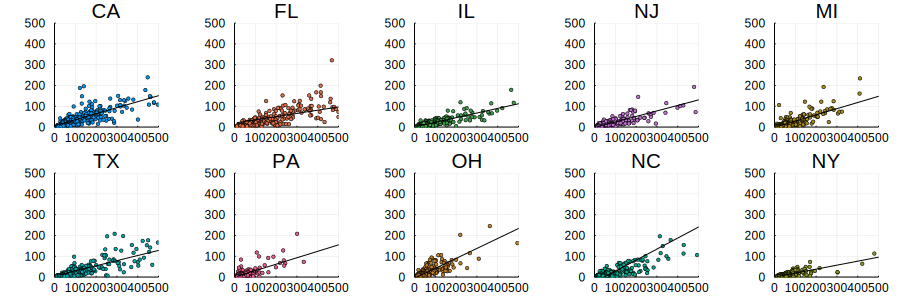

In [37]:
all_plots = Array{Plots.Plot}(undef,length(unique(states_of_interest)))# init un array di plot
for (i,si) in enumerate(states_of_interest)#scorre gli stati + contatore i
    curids = findall(Feb2020data[!,:StateName].==si)#prende dati dello stato si
    data = DataFrame(X=float.(counts[curids]), Y=float.(sales[curids]))#crea df temp con numero case in vendita, numero case vendute
    ols = GLM.lm(@formula(Y ~ X), data) # crea lm temporaneo  
    all_plots[i] = scatter(counts[curids],sales[curids],markersize=2, #crea plot per dati regione aggioungendolo ad array plot
        xlim=(0,500),ylim=(0,500),color=i,aspect_ratio=:equal,
        legend=false,title=si)
    @show si,coef(ols)# parametri del modello (solo b1 poichè intercetta a 0)
    plot!(counts[curids],predict(ols),color=:black)# aggiunge plot modello al plot dei dati
end
plot(all_plots...,layout=(2,5),size=(900,300))### [a,b,c]... = a,b,c, plotta tutti i plot nell array di plot


Proviamo adesso a plottare tutti i modelli/dati nello stesso grafico per confrontare più facilmente i comportamenti delle vendite rispetto al numero di case in vendita di tutti gli stati:

(si, coef(ols)) = ("CA", [6.803086464628306, 0.2879837428995036])
(si, coef(ols)) = ("FL", [19.126255819233393, 0.15510798334559428])
(si, coef(ols)) = ("IL", [0.6626439876883535, 0.22263257658072116])
(si, coef(ols)) = ("NJ", [-1.963591164222573, 0.2650303535602978])
(si, coef(ols)) = ("MI", [-0.918194204170358, 0.2976870503245954])
(si, coef(ols)) = ("TX", [5.241220767319315, 0.24566620049636262])
(si, coef(ols)) = ("PA", [-0.2136244857995347, 0.31019554103097263])
(si, coef(ols)) = ("OH", [-6.026958739166818, 0.47909280478486943])
(si, coef(ols)) = ("NC", [-24.60003985327955, 0.5302793903364811])
(si, coef(ols)) = ("NY", [-0.20048638474402883, 0.19153509216798098])


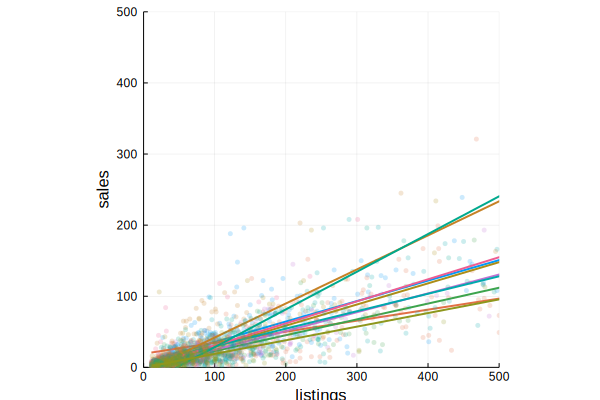

In [38]:
plot()#resetta plot
for (i,si) in enumerate(states_of_interest)
    curids = findall(Feb2020data[!,:StateName].==si)
    data = DataFrame(X=float.(counts[curids]), Y=float.(sales[curids]))
    ols = GLM.lm(@formula(Y ~ X), data)    
    scatter!(counts[curids],sales[curids],markersize=2,
        xlim=(0,500),ylim=(0,500),color=i,aspect_ratio=:equal,
        legend=false,marker=(3,3,stroke(0)),alpha=0.2)
        if si == "NC" || si == "CA" || si == "FL"
            annotate!([(500-20,10+coef(ols)[1]*500,text(si,10))])
        end
    @show si,coef(ols)
    plot!(counts[curids],predict(ols),color=i,linewidth=2)#
end

xlabel!("listings")
ylabel!("sales")
#plotta tutti i dati e tutti i modelli nello stesso plot

### Regressione Logistic
Potremmo trovarci a voler modellare regressione su una variabile binomiale (in pratica un boolean), in questo caso un modello lineare genererebbe valori con poco senso.  
Un modo per modellare modelli che predicano binomiali è creando un modello di regressione logistic.  

NB: dalla logistic non otterremo una predizione sul valore della binomiale che vogliamo predirre ma una predizione sul logit o log-odds $= \log_b{\frac{p}{1-p}} $ tramite modello lineare semplice. Per ottenere una probabilità predetta di avere variabile di target vera per determinati predittori, dovremo quindi trasformare il risultato del modello.

Iniziamo con il prendere dei dati.  
I dati che tratteremo riguardano BWt, HWt e sesso(M/F) di gatti.  
Cerceheremo di creare un modello sul sesso.

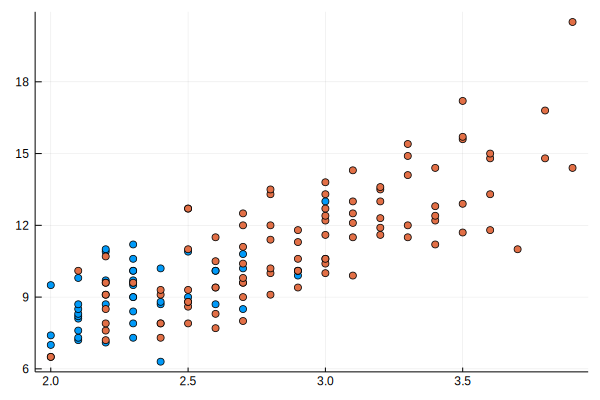

In [42]:
cats = dataset("MASS", "cats");#da rdatasets
lmap = labelmap(cats[!,:Sex])
ci = labelencode(lmap, cats[!,:Sex])
scatter(cats[!,:BWt],cats[!,:HWt],color=ci,legend=false)

Dando colorature diverse ai punti (BWt, HWT) in base al sesso ci sembra già che ci sia relazione lineare tra questi dati ed il sesso.  
Creiamo un modello logistic che predica sesso in base a HWt.  
Useremo laf unzione per la creasione di modelli lineari generici per fare ciò.

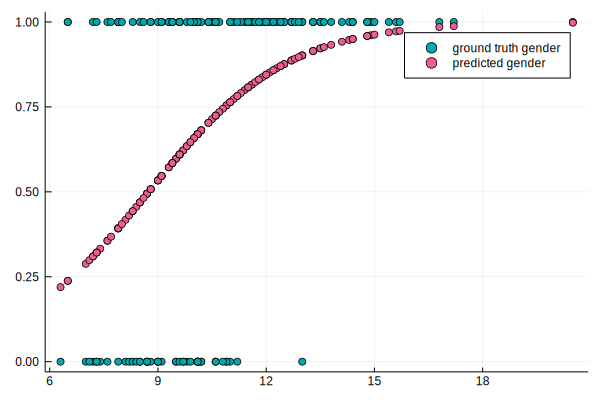

In [43]:
data = DataFrame(X=cats[!,:HWt], Y=ci.-1)
probit = glm(@formula(Y ~ X), data, Binomial(), LogitLink())
scatter(data[!,:X],data[!,:Y],label="ground truth gender",color=6)
scatter!(data[!,:X],predict(probit),label="predicted gender",color=7)

**predict() converte automaticamente il logit predetto dal modello nella probabilità che il gatto sia maschio.**

### Regressione non Lineare
Come ultima cosa proviamo a creare modello nonl ineare, iniziamo da dei dati fittizzi:

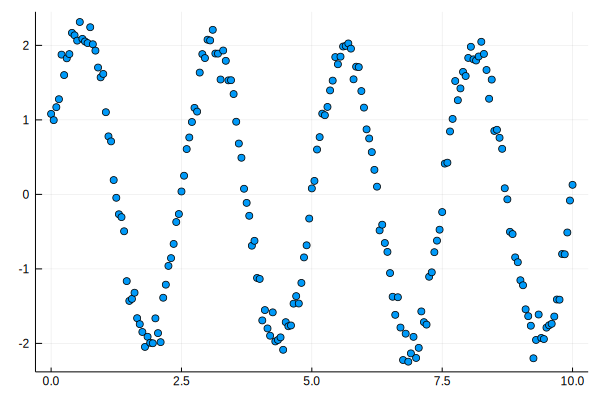

In [45]:

#creiamo dataset
xvals = 0:0.05:10
yvals = 1*exp.(-xvals*2) + 2*sin.(0.8*pi*xvals) + 0.15 * randn(length(xvals));
scatter(xvals,yvals,legend=false)


Il modello lo creeremo con la funzione model()

In [47]:

#facciamo modello
@. model(x, p) = p[1]*exp(-x*p[2]) + p[3]*sin(0.8*pi*x)
p0 = [0.5, 0.5, 0.5]
myfit = curve_fit(model, xvals, yvals, p0);


Vediamo il risultato: 

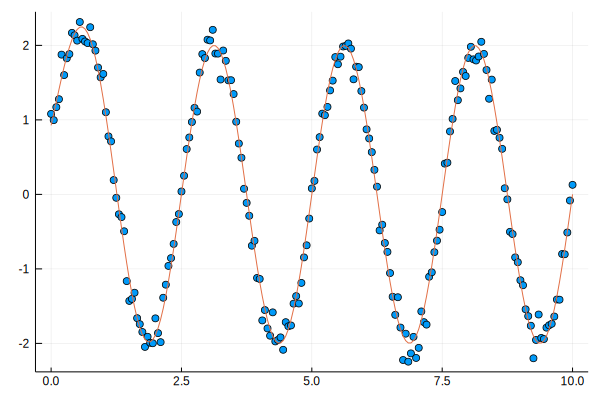

In [48]:

#plottiamo 
p = myfit.param
findyvals = p[1]*exp.(-xvals*p[2]) + p[3]*sin.(0.8*pi*xvals)
scatter(xvals,yvals,legend=false)
plot!(xvals,findyvals)